In [ ]:
# Данный код был написан по туториалу с сайта Tensorflow о генеративных нейросетях.
# Хотя это и моя всего лишь вторая генеративная нейросеть, и в большинстве аспектов её архитектура совпадает с той,
# что представлена на сайте Tensorflow(я изменил некоторые вещи), я могу поручиться, что понимаю все процессы, которые здесь происходят.

In [3]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [4]:
import tensorflow_datasets as tfds
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
train_labels.shape

(60000,)

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5)/127.5 # normalization

In [8]:
train_images.shape

(60000, 28, 28, 1)

In [9]:
buffer_size = 60000
batch_size = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

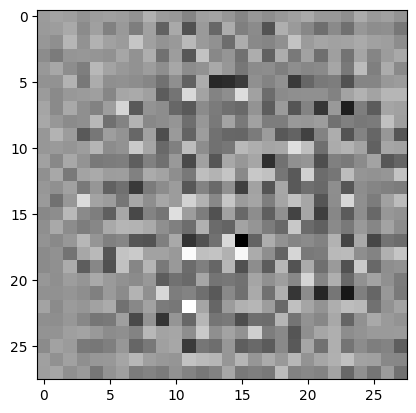

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training=0)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape = [28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [14]:
discriminator = make_discriminator_model()
desicion = discriminator(generated_image)
print(desicion)

tf.Tensor([[-0.00126447]], shape=(1, 1), dtype=float32)


In [15]:
focal_entropy = tf.keras.losses.BinaryFocalCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
  real_loss = focal_entropy(tf.ones_like(real_output), real_output)
  fake_loss = focal_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return focal_entropy(tf.ones_like(fake_output), fake_output)


In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [19]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))


In [20]:

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

      display.clear_output(wait=True)
      generate_and_save_images(generator, epoch + 1, seed) #srry, no saving today

      #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)

      print('time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [21]:
def generate_and_save_images(model, epoch, test_input):
  # `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [22]:
train(train_dataset, epochs)

KeyboardInterrupt: 